In [1]:
push!(LOAD_PATH,"C:/JMB/PhysOcean.jl/src","."); using PhysOcean


In [2]:
push!(LOAD_PATH,"C:/JMB/DIVAnd.jl/src","."); using DIVAnd;cd("C:/JMB/DIVAnd.jl");cd("examples")
using DIVAnd
using PyPlot


Simple example with 

## METRICS usign METERS

In [3]:
dx = dy = 0.2

lonr = 27:dx:42
latr = 40:dy:47


depthr = [0.5, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000];

mask,(pm,pn,po),(xi,yi,zi) = DIVAnd_rectdom(lonr,latr,depthr)
#Now into meters
(pmm,pnm) = DIVAnd_metric(xi[:,:,1],yi[:,:,1])
pm=repeat(pmm,inner = (1,1,length(depthr)));
pn=repeat(pnm,inner = (1,1,length(depthr)));

mask[1:2,:,:]=false
mask[end-1:end,:,:]=false
#mask[:,1:2,:]=false
#mask[:,end-1:end,:]=false


false

Fake data

In [4]:
temp=16-zi/1600+cos.(1.4*xi+0*xi-zi/300)+xi/5.*xi./(zi+1)/2000.*(zi/1000+xi)
salt=28+xi

dens=density.(salt,temp,0)-1025;

In [5]:
Calculate geostrophic velocities assuming level 10 is no motion

LoadError: [91msyntax: extra token "geostrophic" after end of expression[39m

In [6]:
velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);znomotion=10);
eta=eta-mean(eta);

Look at fluxes in y direction (south-north)

In [7]:
@show mean(var(Vflux[1].^2)),mean(var(Vflux[2].^2))

(mean(var(Vflux[1] .^ 2)), mean(var(Vflux[2] .^ 2))) = (4.863047285681978e34, 0.0)


(4.863047285681978e34, 0.0)

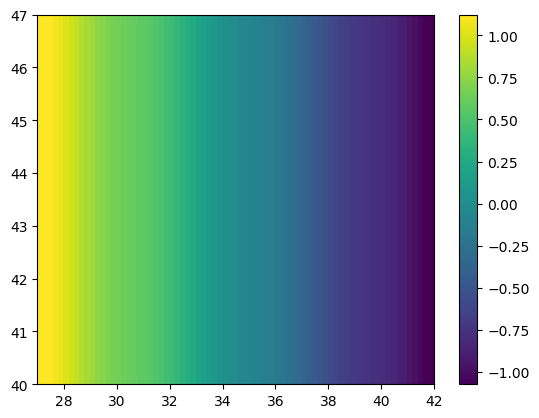

(PyObject <matplotlib.collections.PolyCollection object at 0x000000002BD1B5C0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000002C21D5C0>)

In [8]:
pcolor(xi[:,:,1],yi[:,:,1],eta),colorbar()

Now analyse eta with contstrain to have barotropic flow compensating the fluxes just calculated

In [9]:
# function to interpolate
fun(x,y) = sin.(6x) * cos.(6y)

# observations

x = [35];
y = [42];
f = [0.1]

h=deepestpoint(mask,zi)
len=500000.2
epsilon2=110000
rfluxes=0.0000001

#Need to scale fluxes by f/g
gsf=(earthgravity.(yi)./coriolisfrequency.(yi))[:,:,1]
fi,s=DIVAndrun(mask[:,:,1],(pm[:,:,1],pn[:,:,1]),(xi[:,:,1],yi[:,:,1]),(x,y),f,len,epsilon2;moddim=[0,7],topographyforfluxes=(gsf.*h,0),fluxes=(Vflux[1],0),epsfluxes=rfluxes,alphabc=2,alpha=[1, 0, 1]);

In [10]:
Correction term

LoadError: [91msyntax: extra token "term" after end of expression[39m

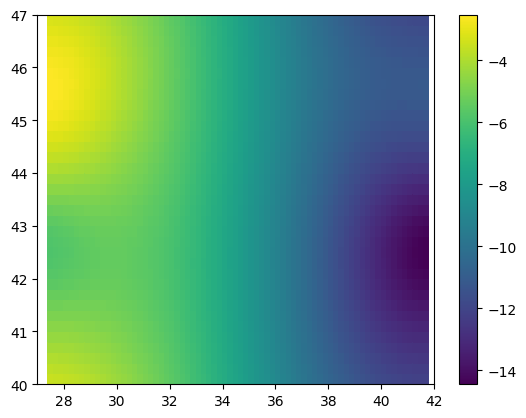

(PyObject <matplotlib.collections.PolyCollection object at 0x000000002C482F28>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003721C518>)

In [11]:
pcolor(xi[:,:,1],yi[:,:,1],fi),colorbar()

For plotting and further calculation

In [12]:
fi[isnan.(fi)]=0

0

For verification look at how the correction term if applied with overall factor 0 to 2 changes fluxes

In [13]:
sf=collect(0.:0.11:2.5)
Ff=zeros(size(sf))
Ff2=zeros(size(sf))
Vfluxafter=0
for i=1:size(sf)[1]

    velafter,etaafter,Vfluxafter=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta+sf[i]*fi);
    Ff[i]=mean(Vfluxafter[1].^2)
    Ff2[i]=mean(Vfluxafter[2].^2)
end


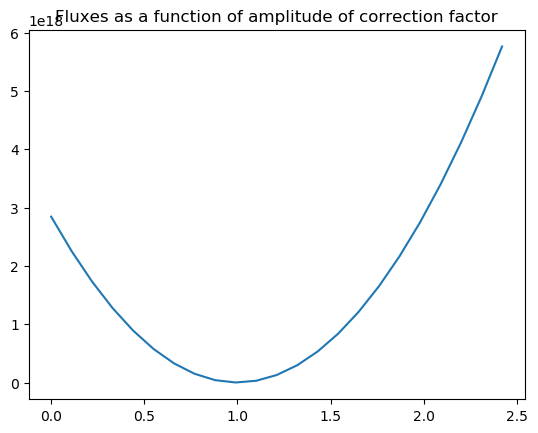

PyObject Text(0.5,1,u'Fluxes as a function of amplitude of correction factor')

In [14]:
plot(sf,Ff)
title("Fluxes as a function of amplitude of correction factor")

In [15]:
mean(Vflux[1].^2)

2.8453192327328553e18

So we can indeed use

In [16]:
velafter,etaafter,Vfluxafter=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta+fi);

In [17]:
mean(Vfluxafter[1].^2)

3.106394389325e15

Verification: if we use zero density anomamy and barotropic correction term we get right flux correction

In [18]:
velafterb,etaafterb,Vfluxafterb=geostrophy(mask,0.0*dens,(pm,pn,po),(xi,yi,zi);ssh=fi);

In [19]:
(Vfluxafterb[1]+Vflux[1])./Vflux[1]

36-element Array{Float64,1}:
 -0.069815  
 -0.0512629 
 -0.0358562 
 -0.0229536 
 -0.0120678 
 -0.0037101 
  0.00428344
  0.0125088 
  0.0212974 
  0.030542  
  0.0397581 
  0.0469838 
  0.0509279 
  ⋮         
 -0.0334491 
 -0.0367445 
 -0.0379523 
 -0.037884  
 -0.0339022 
 -0.0282187 
 -0.0201909 
 -0.0103217 
  0.00127552
  0.0141662 
  0.0289351 
  0.0461003 

In [20]:
psi=streamfunctionvolumeflux(mask,velafter,(pm,pn,po),(xi,yi,zi))

size(Volumeflux) = (36, 26)
size(Volumeflux) = (76, 26)


([-0.596061 -11.8717 … -358.903 -125.714; -0.585289 -11.6565 … -328.314 -91.9276; … ; -0.486698 -9.69031 … -179.389 45.9718; -0.478324 -9.52297 … -155.022 73.006], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

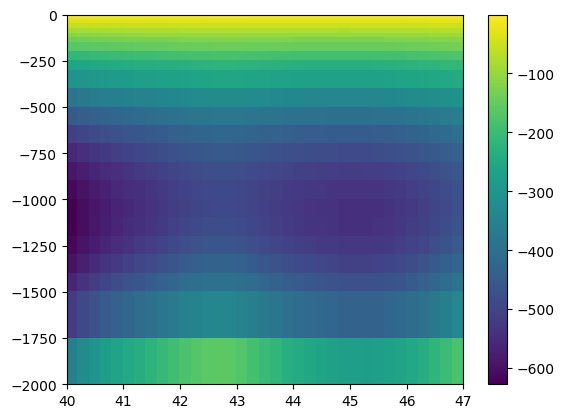

(PyObject <matplotlib.collections.PolyCollection object at 0x00000000376B9A58>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003790C160>)

In [21]:
pcolor(yi[1,:,:],-zi[1,:,:],psi[1]),colorbar()

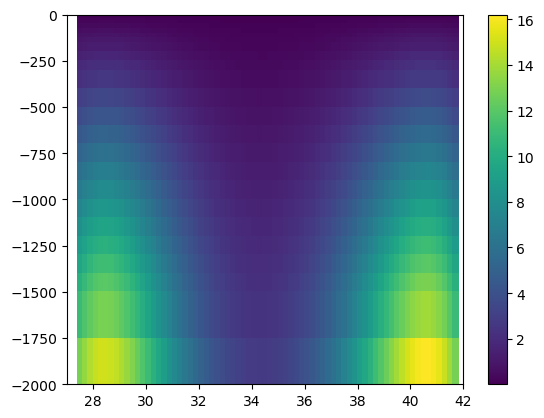

(PyObject <matplotlib.collections.PolyCollection object at 0x0000000037B5EA90>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000037EFCB00>)

In [22]:
pcolor(xi[:,1,:],-zi[:,1,:],psi[2]),colorbar()

In [23]:
psi[1]

36×26 Array{Float64,2}:
 -0.596061  -11.8717   -23.6315  -35.2763  …  -519.691  -358.903  -125.714  
 -0.585289  -11.6565   -23.2014  -34.6319     -492.599  -328.314   -91.9276 
 -0.576017  -11.4713   -22.8314  -34.0776     -469.948  -302.896   -64.0365 
 -0.56794   -11.3099   -22.5092  -33.595      -450.827  -281.585   -40.8269 
 -0.560829  -11.1679   -22.2256  -33.1702     -434.546  -263.576   -21.3781 
 -0.554898  -11.0495   -21.9892  -32.8163  …  -421.747  -249.618    -6.54614
 -0.54918   -10.9353   -21.7613  -32.4751     -409.535  -236.334     7.52771
 -0.543413  -10.8202   -21.5314  -32.1309     -397.119  -222.802    21.8962 
 -0.537452  -10.7011   -21.2938  -31.7751     -384.07   -208.521    37.1341 
 -0.531346  -10.5792   -21.0503  -31.4106     -370.533  -193.66     53.0458 
 -0.525306  -10.4586   -20.8095  -31.0501  …  -357.143  -178.96     68.7855 
 -0.520177  -10.3562   -20.6051  -30.7441     -346.432  -167.377    80.9748 
 -0.516502  -10.2829   -20.4589  -30.5254     -340.0

In [24]:
psi[2]

76×26 Array{Float64,2}:
 NaN           NaN          NaN         …  NaN       NaN       NaN     
 NaN           NaN          NaN            NaN       NaN       NaN     
   0.00367202    0.0734405    0.146881      11.0161   12.8521   14.6881
   0.00388608    0.0777216    0.155443      11.6582   13.6013   15.5443
   0.00408061    0.0816123    0.163225      12.2418   14.2821   16.3225
   0.00421582    0.0843165    0.168633  …   12.6475   14.7554   16.8633
   0.00428842    0.0857684    0.171537      12.8653   15.0095   17.1537
   0.00430263    0.0860526    0.172105      12.9079   15.0592   17.2105
   0.00426495    0.0852991    0.170598      12.7949   14.9273   17.0598
   0.00418279    0.0836558    0.167312      12.5484   14.6398   16.7312
   0.00406382    0.0812765    0.162553  …   12.1915   14.2234   16.2553
   0.00391555    0.078311     0.156622      11.7467   13.7044   15.6622
   0.00374499    0.0748998    0.1498        11.235    13.1075   14.98  
   ⋮                                    

In [25]:
psi[1][:,1]

36-element Array{Float64,1}:
 -0.596061
 -0.585289
 -0.576017
 -0.56794 
 -0.560829
 -0.554898
 -0.54918 
 -0.543413
 -0.537452
 -0.531346
 -0.525306
 -0.520177
 -0.516502
  ⋮       
 -0.529043
 -0.528552
 -0.527219
 -0.525383
 -0.52198 
 -0.51792 
 -0.512949
 -0.50728 
 -0.500963
 -0.494178
 -0.486698
 -0.478324